# CS 4650 Final: Stock Project

### By: Jack Peabody
   


___
### Goal:

Analyze data to inform stock trades. Maximize portfolio value over the 3 week trading period making at least 3 trades a week.

### Strategy:

Develop signals that predict movement in the stock price using several types of analysis including technical analysis (historical stock price activity), fundemental analysis (company financial activity), sentiment analysis (public perception of the stock), and sector/competitor analysis.

### Contents:

- Helpers - Implement functions that will be useful throughout the analysis.
- Phase 1 - Develop a signal for which stocks to buy.
- Phase 2 - Develop a signal for which stocks to sell.
- Phase 3 - Refine analysis to signal the quantity of stocks to buy or sell.

___
# Helpers
Purpose: Implement functions that will be useful throughout the analysis.

In [162]:
# Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import numpy as np
from bs4 import BeautifulSoup
from datetime import date
from sec_api import QueryApi, ExtractorApi
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import LSTM

In [38]:
stock_shortlist_symbols = ["AAPL", "DELL", "GOOGL", "IBM", "KEYS", "LUMN", "META", "MSFT", "NFLX", "NVDA"]

In [39]:
# Return a dictionary mapping stock symbols to a dataframe loaded from the csv at the path
def get_dataframes_from_csv_directory(csv_data_directory_path):
    dfs = {}
    for csv_filename in os.listdir(csv_data_directory_path):
        if ".csv" in csv_filename:
            dfs[csv_filename[:-4]] = pd.read_csv(csv_data_directory_path + csv_filename)
    return dfs

In [124]:
# Generate, show, and save a plot showing the closing prices over the last 90 trading days
# as well as the short and long term moving averages
def generate_moving_averages_lineplot(path_to_csv, plot_save_path, stock_short_term_moving_averages, stock_long_term_moving_averages):
    df = pd.read_csv(path_to_csv)
    stock_short_term_moving_averages_adjusted = []
    for stock_short_term_moving_average in stock_short_term_moving_averages:
        stock_short_term_moving_averages_adjusted += [stock_short_term_moving_average] * 2
    stock_long_term_moving_averages_adjusted = []
    for stock_long_term_moving_average in stock_long_term_moving_averages:
        stock_long_term_moving_averages_adjusted += [stock_long_term_moving_average] * 30
    moving_averages_df = pd.DataFrame({"Day": df.index.values, 
                                       "Daily closing price": df.Close, 
                                       "2 day moving average": stock_short_term_moving_averages_adjusted,
                                       "30 day moving average": stock_long_term_moving_averages_adjusted})
    lineplot = sns.lineplot(x="Day", y="value", hue="variable", data=pd.melt(moving_averages_df, ["Day"]))
    plt.ylabel("Closing Price ($)")
    csv_name = path_to_csv.split("/")[-1][:-4]
    plt.title(csv_name + " Last 90 Days Closing Prices")
    fig = lineplot.get_figure()
    fig.savefig(plot_save_path + csv_name + "_plot.png")
    plt.show()

In [41]:
# Calculate a return a list of the simple moving averages for the given period
def calculate_moving_averages(df, period):
    closing_prices = df.Close.to_numpy()
    moving_averages = list(np.average(closing_prices.reshape(-1, period), axis=1))
    return moving_averages

In [42]:
# Get SEC API key from file
def get_sec_api_key():
    f = open("SEC_API/sec_api_key.txt")
    return f.read().strip()

In [43]:
sec_api_key = get_sec_api_key()

In [44]:
# Get the urls for the most recent 10-Q filings for each company in stock shortlist, write to file
def get_financial_filing_urls(stock_shortlist_symbols):
    urls = []
    queryApi = QueryApi(api_key=sec_api_key)
    df = pd.DataFrame()
    for stock_shortlist_symbol in stock_shortlist_symbols:
        query_filter = "ticker:" + stock_shortlist_symbol + " AND filedAt:[2021-01-01 TO 2023-05-18] AND formType:\"10-Q\"" 
        query = {
          "query": { "query_string": { 
              "query": query_filter,
          } },
          "from": "0",
          "size": "1",
          "sort": [{ "filedAt": { "order": "desc" } }]
        }

        response = queryApi.get_filings(query)
        metadata = pd.DataFrame.from_records(response["filings"])
        if len(df) == 0:
            df = metadata
        else:
            df = pd.concat([df, metadata], ignore_index=True)
    df.to_csv("SEC_API/financial_filing_urls.csv")
    return df

In [45]:
# Get the financial statement data from 10-Q filings, write to CSV file
def get_financial_statements(financial_filing_urls_df):
    extractorApi = ExtractorApi(api_key=sec_api_key)
    stock_symbols = []
    financial_statements = []
    for index, row in financial_filing_urls_df.iterrows():
        stock_symbol = row["ticker"]
        filing_url = row["linkToFilingDetails"]
        financial_statement = extractorApi.get_section(filing_url, "part1item1", "text")
        stock_symbols.append(stock_symbol)
        financial_statements.append(financial_statement)
    d = {"stock_symbol": stock_symbols, "financial_statements": financial_statements}
    df = pd.DataFrame(data=d)
    df.to_csv("SEC_API/financial_statements.csv")
    return df

In [64]:
# Get signals for current ratio, debt ratio, and net income from financial statements dataframe, return dataframe
def get_fundemental_analysis_signals(financial_statements_df):
    stock_symbols = []
    current_ratio_signals = []
    debt_ratio_signals = []
    net_income_signals = []
    data_fields_to_parse = ["Total current assets", "Total current liabilities", "Total liabilities", "Total assets", "Net income"]
    parsed_data = {data_field: [] for data_field in data_fields_to_parse}
    # No statements observed reported negative values for the data fields I used
    for index, row in financial_statements_df.iterrows():
        stock_symbol = row["stock_symbol"]
        stock_symbols.append(stock_symbol)
        financial_statement = row["financial_statements"]
        for data_field in data_fields_to_parse:
            if data_field in financial_statement:
                start_index = financial_statement.find(data_field) + len(data_field) 
                end_index = start_index + 50
                data_split = financial_statement[start_index: end_index].strip().replace("\n", " ").split(" ")
                # Error in API call gives empty value for this entry, enter value from filing
                if data_field == "Net income" and stock_symbol == "IBM":
                    parsed_data[data_field].append(927)
                    break
                for data in data_split:
                    if "," in data and data.replace(",", "").isnumeric():
                        parsed_data[data_field].append(int(data.replace(",", "")))
                        break
                    elif data.isnumeric():
                        parsed_data[data_field].append(int(data))
                        break
    df_dict = {"Stock symbols": stock_symbols, "Current ratio signal": [], "Debt ratio signal": [], "Net income signal": [], "Fundemental analysis signal": []}
    for i in range(len(stock_symbols)):
        current_ratio_signal = 1 if parsed_data["Total current assets"][i] / parsed_data["Total current liabilities"][i] > 3 else 0
        df_dict["Current ratio signal"].append(current_ratio_signal)
        debt_ratio_signal = 1 if parsed_data["Total liabilities"][i] / parsed_data["Total assets"][i] < 0.5 else 0
        df_dict["Debt ratio signal"].append(debt_ratio_signal)
        net_income_signal = 1 if parsed_data["Net income"][i] > 0 else 0
        df_dict["Net income signal"].append(net_income_signal)
        overall_signal = 1 if current_ratio_signal + debt_ratio_signal + net_income_signal >= 3 else 0
        df_dict["Fundemental analysis signal"].append(overall_signal)
    df = pd.DataFrame(data=df_dict)
    df.to_csv("SEC_API/fundemental_analysis_signals.csv")
    return df

In [73]:
# Scrape trending stocks on reddit for stocks on my shortlist, write to csv
def scrape_trending_stocks_on_reddit(stock_shortlist_symbols):
    URL = "https://apewisdom.io/?page=1"
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, "html.parser")
    found_stock_symbols = []
    for a in soup.find_all("a", href=True):
        data = a["href"]
        if "/stocks/" in data:
            stock_symbol = data[8:-1]
            if stock_symbol in stock_shortlist_symbols:
                found_stock_symbols.append(stock_symbol)
    sentiment_analysis_signals = []
    for stock_symbol in stock_shortlist_symbols:
        if stock_symbol in found_stock_symbols:
            sentiment_analysis_signals.append(1)
        else:
            sentiment_analysis_signals.append(0)
    d = {"Stock symbols": stock_shortlist_symbols, "Sentiment analysis signal": sentiment_analysis_signals}
    df = pd.DataFrame(data=d)
    df.to_csv("Sentiment_Analysis_Data/sentiment_analysis_signals_" + str(date.today()) + ".csv")
    return df

In [262]:
# Read data from csv and preprocess dataset for use in LSTM
def get_LSTM_data(path_to_csv, num_lookback, num_predict):
    df = pd.read_csv(path_to_csv)
    dataset = df["Close"]
    dataset = dataset.values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0,1))
    dataset = scaler.fit_transform(dataset)
    X = []
    y = []
    # Add the lookback periods to the X training set and the prediction periods to the y training set
    for i in range(num_lookback, len(dataset) - num_predict + 1):
        X.append(dataset[i - num_lookback: i])
        y.append(dataset[i: i + num_predict])
    last_lookback_set = dataset[len(dataset) - num_lookback:]
    return last_lookback_set, np.array(X), np.array(y), scaler

In [268]:
# Create the model by adding LSTM, dropout, and dense layers
def create_LSTM_model(X_training, y_training, num_lookback, num_predict):
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(num_lookback, 1)))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(units=50))
    lstm_model.add(Dense(units=num_predict))
    lstm_model.compile(loss="mean_squared_error", optimizer="adam")
    lstm_model.fit(X_training, y_training, epochs=50, verbose=0)
    return lstm_model

In [287]:
# Plot the prior and predicted stock prices
def plot_predictions(path_to_csv, plot_save_path, predicted_stock_prices):
    df = pd.read_csv(path_to_csv, usecols=["Close"])
    d = {"Close": predicted_stock_prices.flatten()}
    predictions = pd.DataFrame(data=d)
    plot_data = pd.concat([df, predictions], ignore_index=True)
    plt.plot(plot_data[plot_data.index.values <= len(df)], color = "blue")
    plt.plot(plot_data[plot_data.index.values >= len(df)], color = "red")
    plt.ylabel("Closing Price ($)")
    csv_name = path_to_csv.split("/")[-1][:-4]
    plt.title(csv_name + " Actual and Predicted Prices")
    plt.savefig(plot_save_path + csv_name + "_predictions_plot.png")
    plt.show()

___
# Phase 1 - 5/4/2023
Purpose: Develop a signal for which stocks to buy.

### Company Shortlist:

- Apple (AAPL)
- Dell (DELL)
- Alphabet (GOOGL)
- IBM (IBM)
- Keysight Technologies (KEYS)
- Lumen Technologies (LUMN)
- Meta (META)
- Microsoft (MSFT)
- Netflix (NFLX)
- Nvidia (NVDA)

### Strategy:

**Technical Analysis** - Calculate a short-term simple moving average over the previous 90 days of market activity with a period of 2 days based on the daily closing price. Similarly, calculate a long-term moving average over the previous 90 days of market activity with a period of 30 days based on the daily closing price. If the short-term moving average has crossed above the long-term moving average as of 5/4/2023, this indicates a buy signal.

**Fundemental Analysis** - Analyze company financial statements (balance sheet and income statement) from the previous quarter. Consider the current ratio (current assets / current liabilities), debt ratio (total liabilities / total assets), and net income. Any 2 of the 3 indicates a buy signal: current ratio > 3, debt ratio < 0.5, net income > 0.

**Sentiment Analysis** - Scrape website aggregating stocks trending on Reddit in the past 24 hours. If company included in top 100 trending this indicates a buy signal.

**Overall** - If the company has a buy signal from any 2 out of 3 analysis above, submit buy order for 100 shares at market open 5/5/2023.



### Data Acquisition:

**Technical Analysis** - Download daily stock price data from the last 90 days as a CSV from Yahoo Finance (ex. https://finance.yahoo.com/quote/AAPL/history). Found in the folder Technical_Analysis_Data.

**Fundemental Analysis** - Retrieve financial statements (10-Q) from the SEC API to evaluate the signal (https://sec-api.io/). Save data as a csv to the folder Fundemental_Analysis_Data.

**Sentiment Analysis** - Scrape the top 100 trending reddit stocks from (https://apewisdom.io/?page=1) to evaluate the signal. Save data as a csv to the folder Sentiment_Analysis_Data.





### Implementation:

In [98]:
# Technical Analysis

csv_data_directory_path = "Technical_Analysis_Data/12_23_To_5_4/CSV_Data/"
dfs = get_dataframes_from_csv_directory(csv_data_directory_path)

# Calculate the short-term and long-term moving average, generate a dataframe with the
# symbol for each stock evaluated and whether it meets technical analysis buy signal
stock_short_term_moving_averages = {}
stock_long_term_moving_averages = {}
technical_analysis_stock_symbols = []
technical_analysis_signals = []
for stock_symbol in dfs:
    df = dfs[stock_symbol]
    stock_short_term_moving_averages[stock_symbol] = calculate_moving_averages(df, 2)
    stock_long_term_moving_averages[stock_symbol] = calculate_moving_averages(df, 30)
    technical_analysis_stock_symbols.append(stock_symbol)
    if stock_short_term_moving_averages[stock_symbol][-1] > stock_long_term_moving_averages[stock_symbol][-1]:
        technical_analysis_signals.append(1)
    else:
        technical_analysis_signals.append(0)

technical_analysis_df = pd.DataFrame()
technical_analysis_df["Stock symbols"] = technical_analysis_stock_symbols
technical_analysis_df["Technical analysis signal"] = technical_analysis_signals
technical_analysis_df.sort_values(by="Stock symbols", ascending=1, inplace=True, ignore_index=True)
display(technical_analysis_df)

,Stock symbols,Technical analysis signal
0,AAPL,1
1,DELL,1
2,GOOGL,0
3,IBM,0
4,KEYS,0
5,LUMN,0
6,META,1
7,MSFT,1
8,NFLX,0
9,NVDA,1


In [84]:
# Fundemental Analysis

# Get the financial filing urls from the SEC API, or load saved data from file

# financial_filing_urls_df = get_financial_filing_urls(stock_shortlist_symbols)
financial_filing_urls_df = pd.read_csv("SEC_API/financial_filing_urls.csv", index_col=[0])
financial_filing_urls_df.head(2)

,id,accessionNo,cik,ticker,companyName,companyNameLong,formType,description,filedAt,linkToTxt,linkToHtml,linkToXbrl,linkToFilingDetails,entities,documentFormatFiles,dataFiles,seriesAndClassesContractsInformation,periodOfReport,effectivenessDate
0,fb882bd594c2e70288b490d692759027,0000320193-23-000064,320193,AAPL,Apple Inc.,Apple Inc. (Filer),10-Q,Form 10-Q - Quarterly report [Sections 13 or 1...,2023-05-04T18:03:52-04:00,https://www.sec.gov/Archives/edgar/data/320193...,https://www.sec.gov/Archives/edgar/data/320193...,NaN,https://www.sec.gov/Archives/edgar/data/320193...,"[{'companyName': 'Apple Inc. (Filer)', 'cik': ...","[{'sequence': '1', 'description': '10-Q', 'doc...","[{'sequence': '5', 'description': 'XBRL TAXONO...",[],2023-04-01,NaN
1,3c56e35c3f0f7cf538a46168875335cb,0001571996-22-000044,1571996,DELL,Dell Technologies Inc.,Dell Technologies Inc. (Filer),10-Q,Form 10-Q - Quarterly report [Sections 13 or 1...,2022-12-05T16:13:45-05:00,https://www.sec.gov/Archives/edgar/data/157199...,https://www.sec.gov/Archives/edgar/data/157199...,NaN,https://www.sec.gov/Archives/edgar/data/157199...,[{'companyName': 'Dell Technologies Inc. (File...,"[{'sequence': '1', 'description': '10-Q', 'doc...","[{'sequence': '8', 'description': 'XBRL TAXONO...",[],2022-10-28,NaN


In [83]:
# Fundemental Analysis

# Get the financial statement data from the SEC API, or load saved data from file

# financial_statements_df = get_financial_statements(financial_filing_urls_df)
financial_statements_df = pd.read_csv("SEC_API/financial_statements.csv", index_col=[0])
financial_statements_df.head(2)

,stock_symbol,financial_statements
0,AAPL,PART I &#8212; FINANCIAL INFORMATION \n\nItem...
1,DELL,PART I &#8212; FINANCIAL INFORMATION \n\nITEM...


In [82]:
# Fundemental Analysis

# Evaluate the fundemental analysis signals from the financial statements
fundemental_analysis_signals_df = get_fundemental_analysis_signals(financial_statements_df)
display(fundemental_analysis_signals_df)

,Stock symbols,Current ratio signal,Debt ratio signal,Net income signal,Fundemental analysis signal
0,AAPL,0,0,1,0
1,DELL,0,0,1,0
2,GOOGL,1,1,1,1
3,IBM,0,0,1,0
4,KEYS,1,1,1,1
5,LUMN,0,1,1,0
6,META,0,1,1,0
7,MSFT,0,1,1,0
8,NFLX,0,0,1,0
9,NVDA,1,1,1,1


In [81]:
# Sentiment Analysis

# Get the signal from scraped trending reddit stocks, perform new scrape or load from file

# sentiment_analysis_signals_df = scrape_trending_stocks_on_reddit(stock_shortlist_symbols)
sentiment_analysis_signals_df = pd.read_csv("Sentiment_Analysis_Data/sentiment_analysis_signals_2023-05-04.csv", index_col=[0])
display(sentiment_analysis_signals_df)

,Stock symbols,Sentiment analysis signal
0,AAPL,1
1,DELL,0
2,GOOGL,1
3,IBM,1
4,KEYS,0
5,LUMN,0
6,META,0
7,MSFT,1
8,NFLX,0
9,NVDA,1


In [96]:
# Overall Analysis

# Merge signal dataframes on the stock symbol, create an overall signal
overall_analysis_signals_df = technical_analysis_df.merge(fundemental_analysis_signals_df, on="Stock symbols")
overall_analysis_signals_df = overall_analysis_signals_df.merge(sentiment_analysis_signals_df, on="Stock symbols")
overall_analysis_signals = []
for index, row in overall_analysis_signals_df.iterrows():
    if row["Technical analysis signal"] + row["Fundemental analysis signal"] + row["Sentiment analysis signal"] >= 2:
        overall_analysis_signals.append(1)
    else:
        overall_analysis_signals.append(0)
overall_analysis_signals_df["Overall analysis signal"] = overall_analysis_signals
display(overall_analysis_signals_df)

,Stock symbols,Technical analysis signal,Current ratio signal,Debt ratio signal,Net income signal,Fundemental analysis signal,Sentiment analysis signal,Overall analysis signal
0,AAPL,1,0,0,1,0,1,1
1,DELL,1,0,0,1,0,0,0
2,GOOGL,0,1,1,1,1,1,1
3,IBM,0,0,0,1,0,1,0
4,KEYS,0,1,1,1,1,0,0
5,LUMN,0,0,1,1,0,0,0
6,META,1,0,1,1,0,0,0
7,MSFT,1,0,1,1,0,1,1
8,NFLX,0,0,0,1,0,0,0
9,NVDA,1,1,1,1,1,1,1


**Takeaway**: Submit buy orders for 100 shares of AAPL, GOOGL, MSFT, and NVDA at market open.

### Data Exploration:

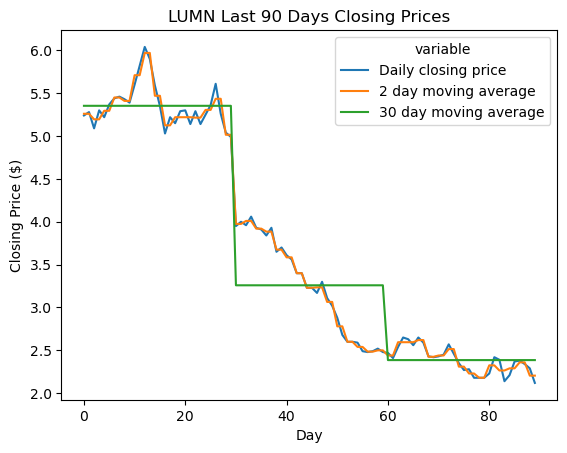

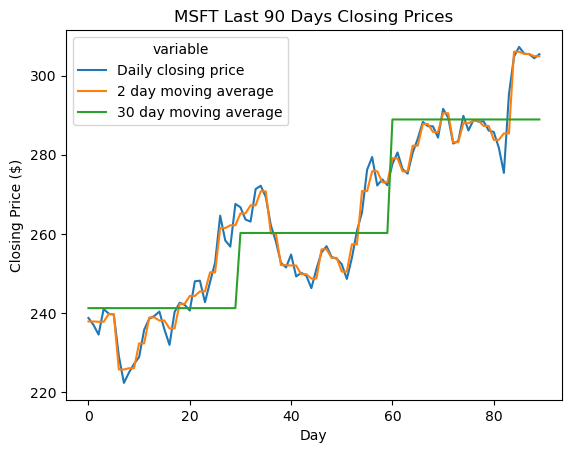

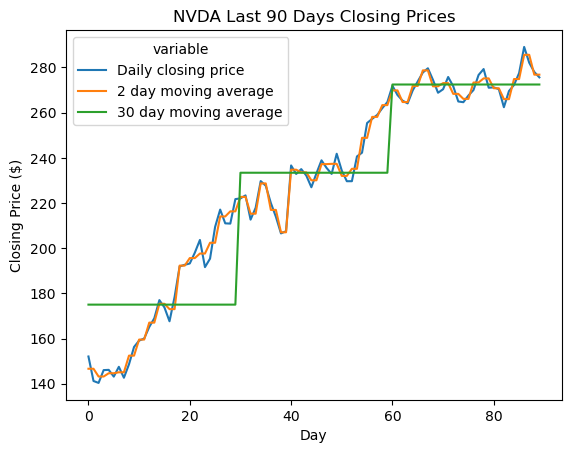

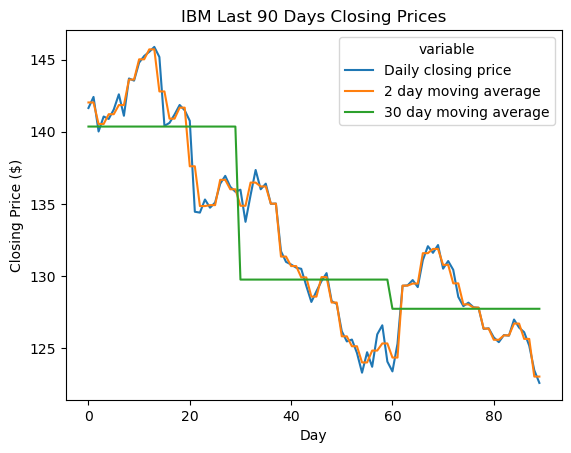

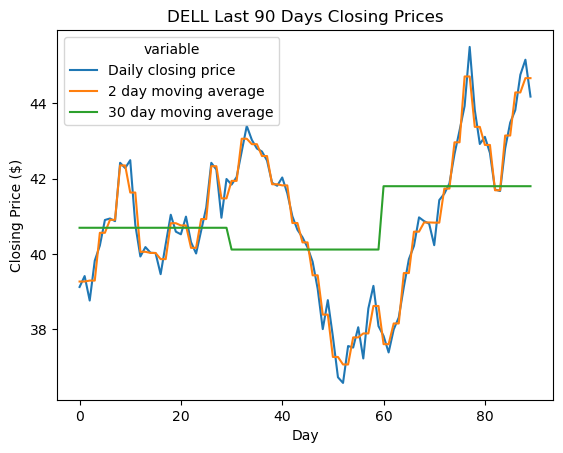

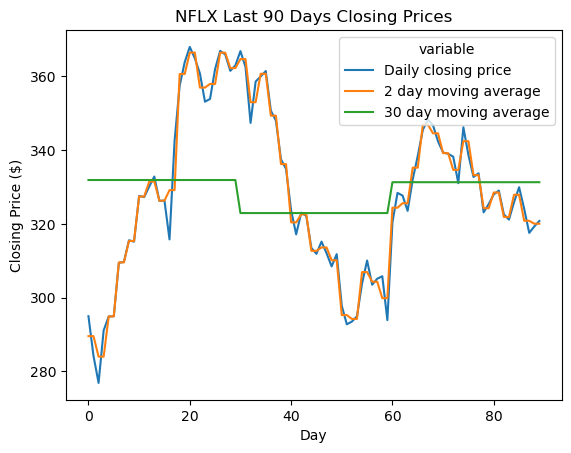

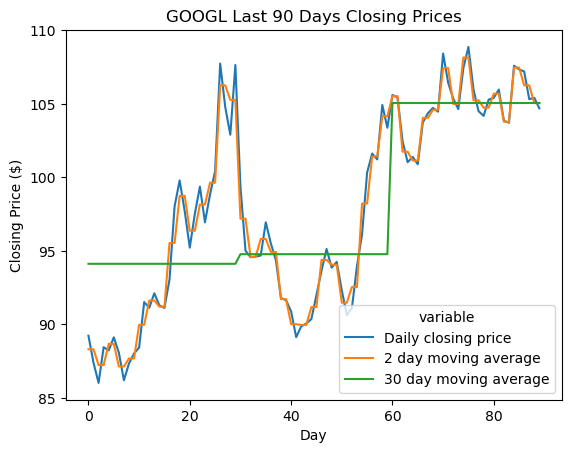

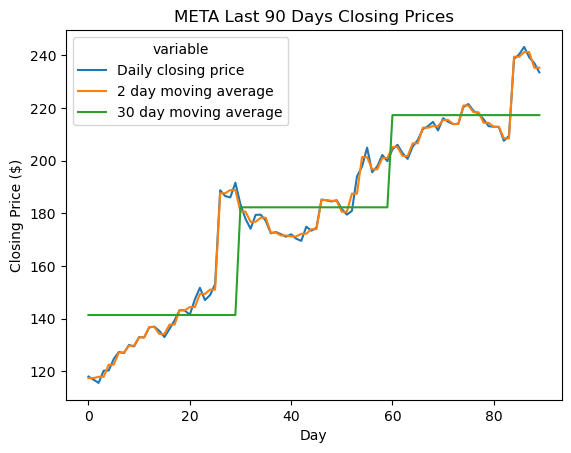

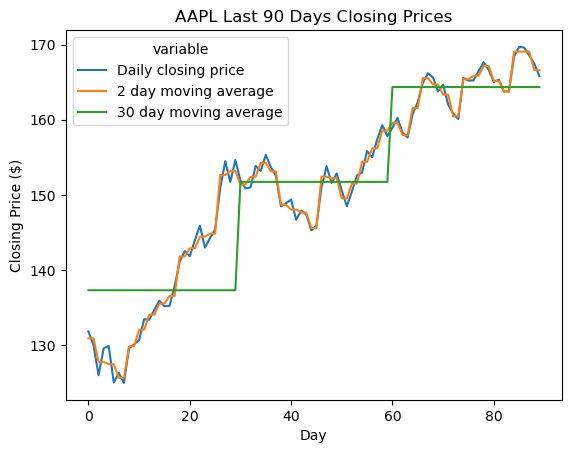

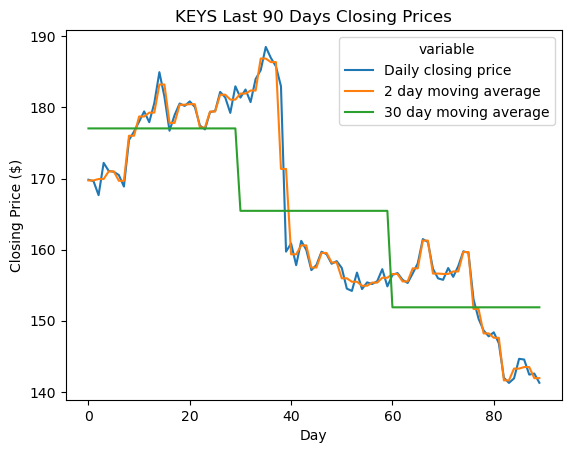

In [126]:
# Technical Analysis

# Display and save a scatterplot of closing prices for each stock on the company shortlist including moving averages
csv_data_directory = "Technical_Analysis_Data/12_23_To_5_4/CSV_Data/"
out_path = "Technical_Analysis_Data/12_23_To_5_4/Lineplots/"
for csv_filename in os.listdir(csv_data_directory):
    if ".csv" in csv_filename:
        stock_symbol = csv_filename[:-4]
        generate_moving_averages_lineplot(csv_data_directory + csv_filename, out_path, stock_short_term_moving_averages[stock_symbol], stock_long_term_moving_averages[stock_symbol])

**Takeaway**: Line plots show moving average crossovers are consistent with the technical analysis signal that I developed.

### Evaluation:

**Stock Price Change Between Phase 1 (5/4) and Phase 2 (5/10)**:

- Apple (AAPL): Bought at 170.98 on 5/5, closing price on 5/10 173.56 , +1.50%
- Dell (DELL): Closing price on 5/4 44.18, closing price on 5/10 45.83, +3.73%
- Alphabet (GOOGL): Bought at 104.82 on 5/5, closing price on 5/10 111.75, +6.61%
- IBM (IBM): Closing price on 5/4 122.57, closing price on 5/10 122.02, -0.44%
- Keysight Technologies (KEYS): Closing price on 5/4 141.27, closing price on 5/10 145.67, +3.11%
- Lumen Technologies (LUMN): Closing price on 5/4 2.12, closing price on 5/10 2.36, +11.32%
- Meta (META): Closing price on 5/4 233.52, closing price on 5/10 233.08, -0.18%
- Microsoft (MSFT): Bought at 305.72 on 5/5, closing price on 5/10 311.63, +1.93%
- Netflix (NFLX): Closing price on 5/4 320.78, closing price on 5/10 335.42, +4.56%
- Nvidia (NVDA): Bought at 278.26 on 5/5, closing price on 5/10 288.85, +3.80%

**Account Value**: $1,002,653.54

**Takeaway**: My signal did a good job of avoiding stocks that lost money over the period observed but didn't signal positive movement for LUMN on any of my analysis signals. Considering that I bought 100 shares of each the gains by my best investment in GOOGL were minimized by the relatively low price of the stock.

**Adaptation**: Consider other factors: sector performance, competitor performance, and upcoming stock events (earnings announcement) to develop a sell signal based on these factors that are not explicitly accounted for in my technical, fundemental, and sentimental analysis. This can be useful for signaling a sudden downward or upward trend in stocks like LUMN that were overlooked by my phase 1 analysis.

___
# Phase 2 - 5/10/2023
Purpose: Develop a signal for which stocks to sell.

### Company Shortlist:

**Sell**

- Apple (AAPL)
- Alphabet (GOOGL)
- Microsoft (MSFT)
- Nvidia (NVDA)

### Strategy:

**Sector Performance** - Develop a signal based on the historical performance of sector tracking ETFs holding the stock, and the stocks relative contribution to the sector performance. Develop a ranking by scoring held stocks, weighting the percentage of the ETF portfolio allocated to a particular stock and the ETFs performance over the past year. The lowest ranking stock receives a sell signal.

**Competitor Performance** - Analyze the performance of 2 competitors for the stock in terms of their price percentage change over the past trading week. This can indicate the relative perception of the stock compared to its competitors in the short term. Rank the price percentage change from the 3 competitors creates a buy signal if it had the performed the best or a sell signal if it performed the worst.

**Stock Event** - Earnings announcements can signal movement in the stock, if the company has an upcoming earnings announcement in the next week of the day I evaluated it then it recieves a buy signal, while if the earnings announcement was within the past week than the movement from the announcement has likely settled and receives a sell signal.

**Overall** - If a stock receives a sell signal from at least any 2 out of the 3 signals defined above it will be sold.

### Data Acquisition:

**Sector Performance** - Evaluate the performance of 3 tech ETFs: Technology Select Sector SPDR Fund (XLK), Vanguard Information Technology ETF (VGT), and Invesco QQQ Trust (QQQ). Get data on their holdings from their websites (https://www.ssga.com/us/en/intermediary/etfs/funds/the-technology-select-sector-spdr-fund-xlk, https://investor.vanguard.com/investment-products/etfs/profile/vgt, https://www.invesco.com/qqq-etf/en/about.html), get data on performance from Yahoo Finance. 

**Competitor Performance** - Get the stock price percentage change over the past year from Yahoo Finance.

**Stock Event** - Get the date for upcoming earnings announcements from SeekingAlpha (ex. https://seekingalpha.com/symbol/GOOGL/earnings).





### Implementation:

**Sell Analysis 5/10**

In [128]:
sell_stock_shortlist_symbols = ["AAPL", "GOOGL", "MSFT", "NVDA"]

In [133]:
# Sector Performance

# Format a dataframe of data from the ETF portfolios; generate score
etf_percentage_price_change = {"XLK": 16.10, "VGT": 15.04, "QQQ": 12.27}
sell_xlk_holdings = [23.49, 0.0, 24.43, 4.93]
sell_vgt_holdings = [23.50, 0.0, 19.30, 6.12]
sell_qqq_holdings = [12.53, 8.31, 13.27, 5.51]
scores = []
for i in range(4):
    score = (sell_xlk_holdings[i] * etf_percentage_price_change["XLK"]) + (sell_vgt_holdings[i] * etf_percentage_price_change["VGT"])+ (sell_qqq_holdings[i] * etf_percentage_price_change["QQQ"])
    scores.append(score)

d = {"Stock symbols": sell_stock_shortlist_symbols, "XLK Holding %": sell_xlk_holdings, 
     "VGT Holding %": sell_vgt_holdings, "QQQ Holding %": sell_qqq_holdings, "Scores": scores}
sell_sector_performance_df = pd.DataFrame(data=d)
display(sell_sector_performance_df)

,Stock symbols,XLK Holding %,VGT Holding %,QQQ Holding %,Scores
0,AAPL,23.49,23.50,12.53,885.3721
1,GOOGL,0.00,0.00,8.31,101.9637
2,MSFT,24.43,19.30,13.27,846.4179
3,NVDA,4.93,6.12,5.51,239.0255


**Takeaway**: GOOGL had the lowest score and receives a sell signal.

In [136]:
# Competitor Performance

# Format dataframes of competitor price percentage change data and develop ranking
competitors = {"AAPL": ["AAPL", "AMD", "BB"], "GOOGL": ["GOOGL", "DIS", "ORCL"], 
               "MSFT": ["MSFT", "SAP", "SONY"], "NVDA": ["NVDA", "AVGO", "CSCO"]}
competitors_current_price = {"AAPL": [173.56, 97.02, 5.23], "GOOGL": [111.75, 101.14, 97.52], 
                             "MSFT": [312.31, 134.83, 93.43], "NVDA": [288.85, 626.27, 46.71]}
competitors_start_of_week_price = {"AAPL": [173.50, 95.04, 5.02], "GOOGL": [107.77, 102.97, 96.79], 
                                   "MSFT": [308.65, 135.78, 92.44], "NVDA": [291.51, 629.06, 46.34]}

for c in competitors:
    d = {"Competitors": competitors[c], "Current Price": competitors_current_price[c], "Start of Week Price": competitors_start_of_week_price[c]}
    df = pd.DataFrame(data=d)
    percentage_price_changes = []
    for i in range(3):
        percentage_price_change = ((competitors_current_price[c][i] - competitors_start_of_week_price[c][i]) / competitors_start_of_week_price[c][i]) * 100.0
        percentage_price_changes.append(percentage_price_change)
    df["Percentage Price Change"] = percentage_price_changes
    df.sort_values("Percentage Price Change", ascending=False, inplace=True, ignore_index=True)
    display(df)

,Competitors,Current Price,Start of Week Price,Percentage Price Change
0,BB,5.23,5.02,4.183267
1,AMD,97.02,95.04,2.083333
2,AAPL,173.56,173.50,0.034582


,Competitors,Current Price,Start of Week Price,Percentage Price Change
0,GOOGL,111.75,107.77,3.693050
1,ORCL,97.52,96.79,0.754210
2,DIS,101.14,102.97,-1.777217


,Competitors,Current Price,Start of Week Price,Percentage Price Change
0,MSFT,312.31,308.65,1.185809
1,SONY,93.43,92.44,1.070965
2,SAP,134.83,135.78,-0.699661


,Competitors,Current Price,Start of Week Price,Percentage Price Change
0,CSCO,46.71,46.34,0.798446
1,AVGO,626.27,629.06,-0.443519
2,NVDA,288.85,291.51,-0.912490


**Takeaway**: Amongst the stocks I hold AAPL and NVDA had the worst weekly stock price performance relative to their competitors and receive a sell signal.

**Stock Event**

- AAPL
    - Previous Earnings Announcement: 5/4/2023
    - Next Earnings Announcement: 8/3/2023
- GOOGL
    - Previous Earnings Announcement: 4/25/2023
    - Next Earnings Announcement: 7/27/2023
- MSFT
    - Previous Earnings Announcement: 4/25/2023
    - Next Earnings Announcement: 7/27/2023
- NVDA
    - Previous Earnings Announcement: 2/22/2023
    - Next Earnings Announcement: 5/24/2023

**Takeaway**: AAPL had earnings in the past week and receives a sell signal.

**Overall** 

AAPL is the only stock which received at least 2 sell signals and has a sell order for market open on 5/11.

### Evaluation

**Takeaway**: The day following the sale AAPL dropped about 1%, representing a good opportunity to sell despite the stock price gaining gradually in the days following.

**Adaptation**: Developing a model to predict the stock price in the future will provide a more precise way to determine the quantity of stocks to buy or sell and when.

___
# Phase 3

## 5/14/2023
Purpose: Develop a model to predict future stock prices to indicate a strong/weak buy signal.

1/1 [==============================] - 0s 227ms/step


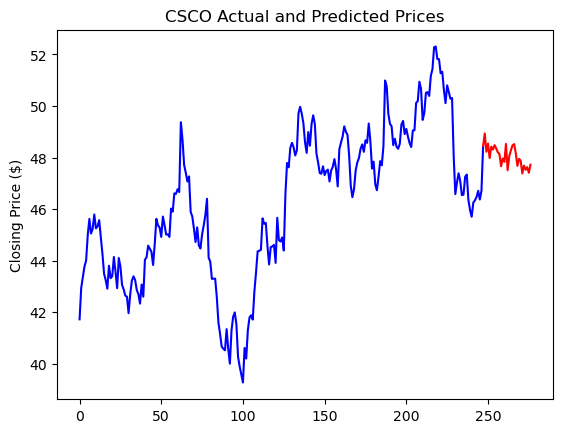

In [288]:
# Predict CSCO prices
num_lookback = 90
num_predict = 30
last_lookback_set, X_training, y_training, scaler = get_LSTM_data("Technical_Analysis_Data/5_19_To_5_12/CSCO.csv", num_lookback, num_predict)
lstm_model = create_LSTM_model(X_training, y_training, num_lookback, num_predict)

last_lookback_set = last_lookback_set.reshape(1, num_lookback, 1)
predicted_stock_prices = lstm_model.predict(last_lookback_set)
predicted_stock_prices = predicted_stock_prices.reshape(-1, 1)
predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices)

plot_predictions("Technical_Analysis_Data/5_19_To_5_12/CSCO.csv", "Technical_Analysis_Data/5_19_To_5_12/", predicted_stock_prices)

In [295]:
# Evaluate predicted CSCO prices
current_price = 46.71
highest_predicted_closing_price = predicted_stock_prices.max()
predicted_percent_gain = ((highest_predicted_closing_price - current_price) / current_price) * 100.0
print(predicted_percent_gain)

4.760823528507846


**Takeaway**: My model predicts the possibility to realize a ~5% gain given the maximum price that it predicted over the next 30 days, this represents a strong signal for a buy opportunity. Submit buy order for 500 shares of CSCO for market open on 5/15.

1/1 [==============================] - 0s 276ms/step


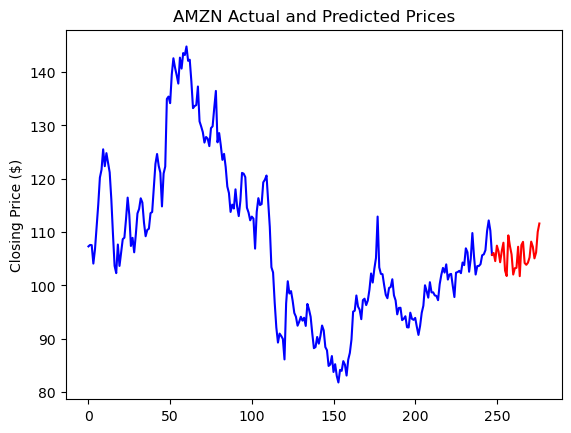

In [301]:
# Predict AMZN prices
num_lookback = 45
num_predict = 30
last_lookback_set, X_training, y_training, scaler = get_LSTM_data("Technical_Analysis_Data/5_19_To_5_12/AMZN.csv", num_lookback, num_predict)
lstm_model = create_LSTM_model(X_training, y_training, num_lookback, num_predict)

last_lookback_set = last_lookback_set.reshape(1, num_lookback, 1)
predicted_stock_prices = lstm_model.predict(last_lookback_set)
predicted_stock_prices = predicted_stock_prices.reshape(-1, 1)
predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices)

plot_predictions("Technical_Analysis_Data/5_19_To_5_12/AMZN.csv", "Technical_Analysis_Data/5_19_To_5_12/", predicted_stock_prices)

In [304]:
# Evaluate predicted AMZN prices
current_price = 110.26
highest_predicted_closing_price = predicted_stock_prices.max()
predicted_percent_gain = ((highest_predicted_closing_price - current_price) / current_price) * 100.0
print(predicted_percent_gain)

1.2224072491476066


**Takeaway**: Looking at the chart for AMZN, the stock had a significant surge in the last 45 days so I was interested in adjusting the lookback period to reflect this. However even still a 1.22% maximum predicted gain represents only a weak buying opportunity. Submit buy order for 100 shares of AMZN for market open on 5/15.

## 5/19/2023
Purpose: Scale the amount of stock to buy based on the maximum predicted percent percent gain.

1/1 [==============================] - 0s 253ms/step


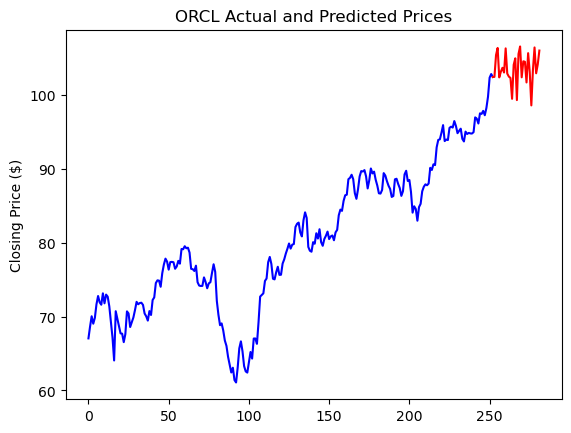

In [308]:
# Predict ORCL prices
num_lookback = 30
num_predict = 30
last_lookback_set, X_training, y_training, scaler = get_LSTM_data("Technical_Analysis_Data/5_18_To_5_19/ORCL.csv", num_lookback, num_predict)
lstm_model = create_LSTM_model(X_training, y_training, num_lookback, num_predict)

last_lookback_set = last_lookback_set.reshape(1, num_lookback, 1)
predicted_stock_prices = lstm_model.predict(last_lookback_set)
predicted_stock_prices = predicted_stock_prices.reshape(-1, 1)
predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices)

plot_predictions("Technical_Analysis_Data/5_18_To_5_19/ORCL.csv", "Technical_Analysis_Data/5_18_To_5_19/", predicted_stock_prices)

In [309]:
# Evaluate predicted ORCL prices
current_price = 102.84
highest_predicted_closing_price = predicted_stock_prices.max()
predicted_percent_gain = ((highest_predicted_closing_price - current_price) / current_price) * 100.0
print(predicted_percent_gain)

3.6286845554038702


**Takeaway**: A 3.62% predicted maximum gain over the next 30 days will be scaled to 100 shares per percentage gain, submitting a buy order for 362 shares of ORCL on market open 5/20.

1/1 [==============================] - 0s 247ms/step


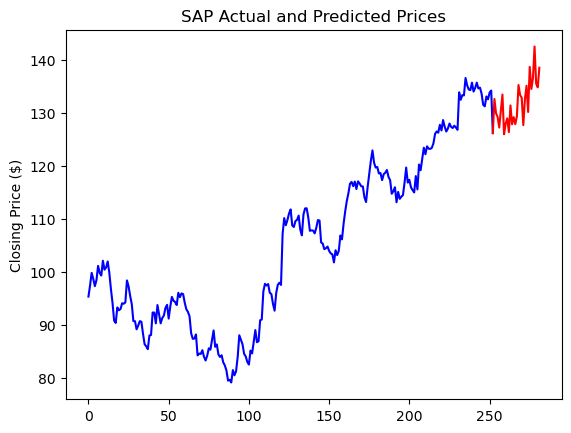

In [310]:
# Predict SAP prices
num_lookback = 30
num_predict = 30
last_lookback_set, X_training, y_training, scaler = get_LSTM_data("Technical_Analysis_Data/5_18_To_5_19/SAP.csv", num_lookback, num_predict)
lstm_model = create_LSTM_model(X_training, y_training, num_lookback, num_predict)

last_lookback_set = last_lookback_set.reshape(1, num_lookback, 1)
predicted_stock_prices = lstm_model.predict(last_lookback_set)
predicted_stock_prices = predicted_stock_prices.reshape(-1, 1)
predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices)

plot_predictions("Technical_Analysis_Data/5_18_To_5_19/SAP.csv", "Technical_Analysis_Data/5_18_To_5_19/", predicted_stock_prices)

In [311]:
# Evaluate predicted SAP prices
current_price = 134.28
highest_predicted_closing_price = predicted_stock_prices.max()
predicted_percent_gain = ((highest_predicted_closing_price - current_price) / current_price) * 100.0
print(predicted_percent_gain)

6.20093324335693


**Takeaway**: A 6.20% predicted maximum gain over the next 30 days will be scaled to 100 shares per percentage gain, submit a buy order for 620 shares of SAP on market open 5/20.